In [1]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install easypip")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("bbrl>=0.2.2")
easyinstall("swig")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("bbrl_gymnasium[box2d]")
easyinstall("bbrl_gymnasium[classic_control]")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")


[notice] A new release of pip is available: 23.3 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import sys
from pathlib import Path
import math
import time

from moviepy.editor import ipython_display as video_display
import time
from tqdm.auto import tqdm
from typing import Tuple, Optional
from functools import partial

import torch
import bbrl_gymnasium

import copy
from abc import abstractmethod, ABC
import torch.nn as nn
import torch.nn.functional as F
from time import strftime

In [3]:
from datetime import datetime
from datetime import date

import base64
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

import gymnasium
from gymnasium import logger as gymlogger
# from gym.wrappers import Monitor # deprecated 2023 - https://stackoverflow.com/questions/71520568/importerror-cannot-import-name-monitor-from-gym-wrappers
from gymnasium.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

print("\n",date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")

def show_video(loop=True, num=0):
    mp4list = glob.glob(f'videoTest/rl-video-episode-{num}.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        if loop == True:
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:videoTest/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
        else:
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    controls style="height: 400px;">
                    <source src="data:videoTest/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
def wrap_env(env):
    env = RecordVideo(env, './videoTest',  episode_trigger = lambda episode_number: True) # !!! 2023
    env.reset() # !!! 2023
    #env = Monitor(env, './video', force=True)
    return env


 2024-01-15 17:12:34 GMT
OK.


In [4]:
"""
Continuous action version of the classic cart-pole system implemented by Rich
Sutton et al.
"""
import math

import numpy as np

from gymnasium.envs.classic_control.cartpole import CartPoleEnv
from gymnasium import logger, spaces
from gymnasium.wrappers import TimeLimit

import sys
sys.modules[__name__]

class ContinuousEnvArticle(CartPoleEnv):
    """Continuous version  of the CartPole-v1 environment"""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.min_action = -1.0
        self.max_action = 1.0
        self.action_space = spaces.Box(
            self.min_action, self.max_action, shape=(1,), dtype=np.float64
        )
        self.tau = 0.1
        
        self.x_threshold = 1

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                self.theta_threshold_radians * 2,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

    def step(self, action):
        if action > self.max_action:
            action = np.array(self.max_action)
        elif action < self.min_action:
            action = np.array(self.min_action)
        assert self.state is not None, "Call reset before using step method."

        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag * float(action)

        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * theta_dot**2 * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not terminated:
            reward = 1.0
        elif self.steps_beyond_terminated is None:
            # Pole just fell!
            self.steps_beyond_terminated = 0
            reward = -1.0
        else:
            if self.steps_beyond_terminated == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned terminated = True. You "
                    "should always call 'reset()' once you receive 'terminated = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_terminated += 1
            reward = 0

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}
    
    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        x = self.np_random.uniform(low=-0.05, high=0.05, size=(1,))
        self.state = 0, 0, x, 0
        self.steps_beyond_terminated = None

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}
"""
Continuous action version of the classic cart-pole system implemented by Rich
Sutton et al.
"""
import math

import numpy as np

from gymnasium.envs.classic_control.cartpole import CartPoleEnv
from gymnasium import logger, spaces
from gymnasium.wrappers import TimeLimit

import sys
sys.modules[__name__]

class ContinuousEnvCACLA(CartPoleEnv):
    """Continuous version  of the CartPole-v1 environment"""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.min_action = -1.0
        self.max_action = 1.0
        self.action_space = spaces.Box(
            self.min_action, self.max_action, shape=(1,), dtype=np.float64
        )

    def step(self, action):
        
        if action > self.max_action:
            action = np.array(self.max_action)
        elif action < self.min_action:
            action = np.array(self.min_action)
        assert self.state is not None, "Call reset before using step method."
        
        #err_msg = f"{action!r} ({type(action)}) invalid"
        #print(self.action_space)
        #assert self.action_space.contains(action), err_msg

        x, x_dot, theta, theta_dot = self.state
        

        force = self.force_mag * float(action)

        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * theta_dot**2 * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not terminated:
            reward = 1.0
        elif self.steps_beyond_terminated is None:
            # Pole just fell!
            self.steps_beyond_terminated = 0
            reward = -1.0
        else:
            if self.steps_beyond_terminated == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned terminated = True. You "
                    "should always call 'reset()' once you receive 'terminated = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_terminated += 1
            reward = 0

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

try:
  gymnasium.envs.register(
      id='CartpoleEnvCacla',
      entry_point='__main__:ContinuousEnvCACLA',
      max_episode_steps=500
  )
except:
    print("Except")
    pass
try:
  gymnasium.envs.register(
      id='CartpoleEnvArticle',
      entry_point='__main__:ContinuousEnvArticle',
      max_episode_steps=500
  )
except:
    print("Except")
    pass


In [12]:
from tqdm import tqdm
from torch.nn.functional import mse_loss
class Cacla(nn.Module):
    def __init__(self, in_dim, 
                 h_dim, activation=nn.Tanh,
                 discount_factor=0.95, 
                 gaussian_noise=0.01, 
                 var=False, 
                 exploration='gaussian'):
        super(Cacla,self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(in_dim, h_dim),
            activation(),
            nn.Linear(h_dim, 1),
            #activation()
        )
        
        self.actor = nn.Sequential(
            nn.Linear(in_dim, h_dim),
            activation(),
            nn.Linear(h_dim, 1,bias= False)
        )
        
        self.discount_factor = discount_factor
        self.gaussian_noise = gaussian_noise
        self.vart = 1
        self.beta = 0.001
        self.with_var = var

        self.eps = 1
        self.eps_decay = 0.99
        self.eps_min = 0.01
        
        self.exploration = 'gaussian'
    
    def forward(self, x, testing=False):
        x = torch.from_numpy(x).unsqueeze(0)
        if testing: return (None, self.actor(x)) 
        return self.critic(x), self.actor(x)
    
    # Loss computation
    def compute_critic_loss(self, value, target):
        delta = (target - value).detach()
        loss =  mse_loss(value, target)
        n_update = 1
        if self.with_var and delta > 0:
            n_update = torch.ceil(delta/np.sqrt(self.vart)).item()
            self.vart = (1-self.beta)*self.vart +self.beta*loss.detach()
        return loss, int(n_update)
    
    def compute_actor_loss(self, value, target):
        return mse_loss(value, target)
    
    # Exploration
    def sample(self, x):
        if self.exploration == 'gaussian':
            return self.sample_gaussian(x)
        elif self.exploration == 'epsilon':
            return self.sample_epsilon(x)
        else: 
            print('Exploration unknown: ', self.exploration)       
    
    def sample_gaussian(self, x):
        return (x + np.random.normal(0,self.gaussian_noise))
    
    def sample_epsilon(self, x, inf=-1, sup=1):
        if torch.rand(1) > self.eps: return x
        else: return np.random.rand() * (sup - inf) - inf


def test(eval_env, model, n_test = 10, noise_std = 0.3):
    cum_reward = 0
    with torch.no_grad():
        for _ in range(n_test):
            done = False
            truncated = False
            obs0,_ = eval_env.reset()
            while not done and not truncated:
                _, a0 = model(obs0, testing=True)
                obs0, reward, done,truncated,_ = eval_env.step(np.array([a0.detach().item()])) 
                cum_reward += reward
    return cum_reward/n_test

def addnoise(x, std):
    return x + np.random.normal(0,std)
    
def train(eval_env, 
          train_env,
          model,
          optim, 
          eval_interval=1000, 
          step_max=100000, 
          n_test=10, 
          noise_std=0.3):
    obs ,_ = train_env.reset()
    scores = []
    optim_critic, optim_actor = optim
    # boucle d'apprentissage
    for it in range(step_max+1):
        v0, a0 = model(obs)
        obs0 = obs
        action = model.sample(a0).detach()
        act = np.array([action.item()])
        #print("ok ",act)
        #obs, reward, done, truncated,reste = train_env.step(addnoise(act, noise_std)) 
        obs, reward, done, truncated,reste = train_env.step(act) 
        
        # Compute losses
        with torch.no_grad(): v1, _ = model(obs)
        target_v = addnoise(reward, noise_std) + model.discount_factor*v1
        optim_critic.zero_grad()
        critic_loss, n_update = model.compute_critic_loss(v0, target=target_v)
        critic_loss.backward()
        optim_critic.step()
        if target_v - v0 > 0: 
            for _ in range(n_update):
                optim_actor.zero_grad()
                mse_loss(model(obs0)[1], action).backward()
                optim_actor.step()
        if done or truncated: obs,_ = train_env.reset()
        if it % eval_interval == 0:
            perf = test(eval_env, model, n_test, noise_std)
            scores.append((it, perf))
            print(f'{it = } | reward {perf}')
    return scores



In [14]:
from torch.optim import SGD, Adam
# Initialisation

def make_env(env_name, max_episode_steps= 500):
    return TimeLimit(gymnasium.make(env_name), max_episode_steps)

env_name = 'CartpoleEnvCacla'
max_episode = 500
train_env = make_env(env_name, max_episode_steps=max_episode)
eval_env = make_env(env_name, max_episode_steps=max_episode)

all_perfs = []
n_runs = 1
discount_factor = 0.9
noise_std= 0.3
exploration = 'gaussian'
var = False
path = f'log/{exploration}/now_novar_gamma{int(discount_factor*100)}_std{noise_std}'

if not os.path.exists(path): 
    print()
    os.mkdir(path)

for run in range(1,n_runs+1):
    print(f'======= {run = } / {n_runs} =========')
    cacla = Cacla(in_dim=4, h_dim=36, 
                  discount_factor=discount_factor, 
                  gaussian_noise=0.1,
                 var=var,
                 exploration=exploration)
    optim_crit = SGD(cacla.critic.parameters(), lr=0.01)
    optim_act = SGD(cacla.actor.parameters(), lr=0.01)
    optim = (optim_crit, optim_act)
    scores = train(eval_env, train_env, cacla, optim, 
                   eval_interval=1024, 
                   step_max=102400,
                  n_test=10,
                  noise_std= noise_std)
    scores = np.array(scores)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    np.savetxt(path+f'/{timestr}.log', scores)

======= run = 1 / 1 =========
it = 0 | reward 36.1
it = 1024 | reward 46.2
it = 2048 | reward 34.9
it = 3072 | reward 31.8
it = 4096 | reward 56.2
it = 5120 | reward 69.0
it = 6144 | reward 94.3
it = 7168 | reward 46.9
it = 8192 | reward 138.4
it = 9216 | reward 157.7
it = 10240 | reward 124.4
it = 11264 | reward 124.9
it = 12288 | reward 75.0
it = 13312 | reward 181.7
it = 14336 | reward 124.3
it = 15360 | reward 178.1
it = 16384 | reward 320.8
it = 17408 | reward 184.8
it = 18432 | reward 109.1
it = 19456 | reward 160.5
it = 20480 | reward 221.8
it = 21504 | reward 143.1
it = 22528 | reward 339.3
it = 23552 | reward 356.4
it = 24576 | reward 157.5
it = 25600 | reward 447.1
it = 26624 | reward 302.5
it = 27648 | reward 233.1
it = 28672 | reward 189.0
it = 29696 | reward 158.5
it = 30720 | reward 113.7
it = 31744 | reward 340.7
it = 32768 | reward 103.9
it = 33792 | reward 300.5
it = 34816 | reward 186.3
it = 35840 | reward 121.7
it = 36864 | reward 354.9
it = 37888 | reward 372.7
it =

Les bornes actions sont [ 0.75200462 -0.91351861] et les bornes etat sont [ 2.44753194 -2.45538521  0.2296841  -0.24339156  2.99952817 -3.0505054
  1.55276    -2.181077  ] et bornes critic[11.54955292 -0.19350152]



In [15]:
rec_env = wrap_env(TimeLimit(ContinuousEnvCACLA(render_mode='rgb_array'),max_episode_steps=500))
observation, _ = rec_env.reset()
maxEvaluations = 2
evaluation = 0
score = []
total = 0
while evaluation < maxEvaluations:
    rec_env.render()
    _, a0 = cacla(observation)  
    action = a0
    observation, reward, done, truncated, _ = rec_env.step(action) 
    total += reward
    if done or truncated:
      score.append(total)
      total = 0
      evaluation = evaluation + 1
      observation, _ = rec_env.reset()
rec_env.close()
score

Moviepy - Building video /users/nfs/Etu3/28604113/IAR/PROJET_IAR/cacla/videoTest/rl-video-episode-0.mp4.
Moviepy - Writing video /users/nfs/Etu3/28604113/IAR/PROJET_IAR/cacla/videoTest/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /users/nfs/Etu3/28604113/IAR/PROJET_IAR/cacla/videoTest/rl-video-episode-0.mp4
Moviepy - Building video /users/nfs/Etu3/28604113/IAR/PROJET_IAR/cacla/videoTest/rl-video-episode-1.mp4.
Moviepy - Writing video /users/nfs/Etu3/28604113/IAR/PROJET_IAR/cacla/videoTest/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /users/nfs/Etu3/28604113/IAR/PROJET_IAR/cacla/videoTest/rl-video-episode-1.mp4
Moviepy - Building video /users/nfs/Etu3/28604113/IAR/PROJET_IAR/cacla/videoTest/rl-video-episode-2.mp4.
Moviepy - Writing video /users/nfs/Etu3/28604113/IAR/PROJET_IAR/cacla/videoTest/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /users/nfs/Etu3/28604113/IAR/PROJET_IAR/cacla/videoTest/rl-video-episode-2.mp4


[350.0, 349.0]

In [17]:
show_video(num=0)

## Visualisation

In [12]:
def get(path):
    X = []
    for data_file in os.listdir(path):
        filepath = path + data_file 
        X.append(np.loadtxt(filepath)[:,:1227])
    return np.array(X)
#path = 'log/gaussian/gamma90/'


(10, 100, 2)

## CACLA

In [29]:
X = get('./log/gaussian/now_novar_gamma90_std0.3/')
X.shape

(2, 100, 2)

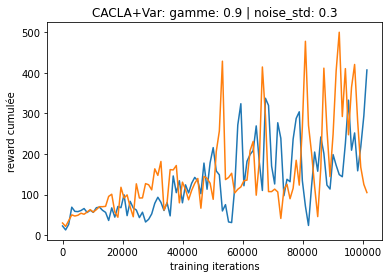

In [30]:
for x in X:
    plt.plot(x[:,0], x[:,1], alpha=1)
    #break
plt.title(f'CACLA+Var: gamme: {discount_factor} | noise_std: {noise_std}')
plt.xlabel('training iterations')
plt.ylabel('reward cumulée')
plt.show()

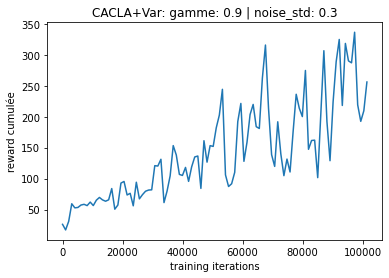

In [31]:
x = X.mean(0)
plt.plot(x[:,0], x[:,1])
plt.title(f'CACLA+Var: gamme: {discount_factor} | noise_std: {noise_std}')
plt.xlabel('training iterations')
plt.ylabel('reward cumulée')
plt.show()

## CACLA + VAR

In [32]:
X = get('./log/gaussian/now_gamma90_std0.3/')
X.shape

(10, 100, 2)

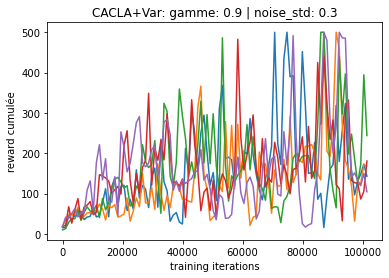

In [35]:
for x in X[:5]:
    plt.plot(x[:,0], x[:,1], alpha=1)
    #break
plt.title(f'CACLA+Var: gamme: {discount_factor} | noise_std: {noise_std}')
plt.xlabel('training iterations')
plt.ylabel('reward cumulée')
plt.show()

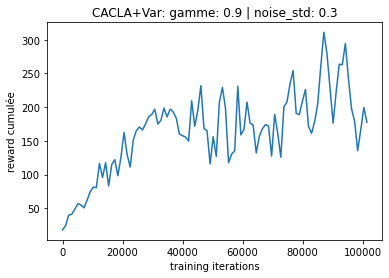

In [34]:
x = X.mean(0)
plt.plot(x[:,0], x[:,1])
plt.title(f'CACLA+Var: gamme: {discount_factor} | noise_std: {noise_std}')
plt.xlabel('training iterations')
plt.ylabel('reward cumulée')
plt.show()

In [66]:
from tqdm import tqdm
from torch.nn.functional import mse_loss
class Cacla(nn.Module):
    def __init__(self, in_dim, 
                 h_dim, activation=nn.Tanh,
                 discount_factor=0.95, 
                 gaussian_noise=0.01, 
                 var=False, 
                 exploration='gaussian'):
        super(Cacla,self).__init__()
        self.critic = nn.Sequential(
            nn.Linear(in_dim, h_dim),
            activation(),
            nn.Linear(h_dim, 1),
            #activation()
        )
        
        self.actor = nn.Sequential(
            nn.Linear(in_dim, h_dim),
            activation(),
            nn.Linear(h_dim, 1),
        )
        
        self.discount_factor = discount_factor
        self.gaussian_noise = gaussian_noise
        self.vart = 1
        self.beta = 0.001
        self.with_var = var

        self.eps = 1
        self.eps_decay = 0.99
        self.eps_min = 0.01
        
        self.exploration = 'gaussian'
        # ordre : xmax, xmin, xprimemax, xprimemin, thetamax, thetamin, thetaprimemax, thetaprimemin
        self.bornes = np.array([np.inf for i in range(8)])
        self.actbornes = np.array([np.inf for i in range(2)])
        self.vbornes = np.array([np.inf,np.inf])
    
    def forward(self, x, testing=False):
        x = torch.from_numpy(x).unsqueeze(0)
        if testing: return (None, self.actor(x)) 
        
        res = self.critic(x), self.actor(x)
        
        # mise a jour des bornes des actions (pour normaliser entre -1 et 1)
        # cas initial
        """if self.actbornes[0] == np.inf :
            self.actbornes[0] = res[1].detach()
            self.actbornes[1] = res[1].detach()
            self.vbornes[0] = res[0].detach()
            self.vbornes[1] = res[0].detach()
        
        self.actbornes[0] = np.max((self.actbornes[0], res[1].detach()))
        self.actbornes[1] = np.min((self.actbornes[1], res[1].detach()))
        self.vbornes[0] = np.max((self.vbornes[0], res[0].detach()))
        self.vbornes[1] = np.min((self.vbornes[1], res[0].detach()))"""

        return res
    
    # Loss computation
    def compute_critic_loss(self, value, target):
        delta = (target - value).detach()
        loss =  mse_loss(value, target)
        n_update = 1
        if self.with_var and delta > 0:
            n_update = torch.ceil(delta/np.sqrt(self.vart)).item()
            self.vart = (1-self.beta)*self.vart +self.beta*loss.detach()
        return loss, int(n_update)
    
    def compute_actor_loss(self, value, target):
        return mse_loss(value, target)
    
    # Exploration
    def sample(self, x):
        if self.exploration == 'gaussian':
            return self.sample_gaussian(x)
        elif self.exploration == 'epsilon':
            return self.sample_epsilon(x)
        else: 
            print('Exploration unknown: ', self.exploration)       
    
    def sample_gaussian(self, x):
        return (x + np.random.normal(0,self.gaussian_noise))
    
    def sample_epsilon(self, x, inf=-1, sup=1):
        if torch.rand(1) > self.eps: return x
        else: return np.random.rand() * (sup - inf) - inf
        
    # Mise à jour des facteurs pour la normalisation
    def updateB(self,x,theta,xprime,thetaprime):
        # Le cas initial
        if self.bornes[0] == np.inf :
            self.bornes[0] = x
            self.bornes[1] = x
            self.bornes[2] = xprime
            self.bornes[3] = xprime
            self.bornes[4] = theta
            self.bornes[5] = theta
            self.bornes[6] = thetaprime
            self.bornes[7] = thetaprime
        
        # update x, xprime, theta et thetaprime
        self.bornes[0] = np.max((self.bornes[0],x))
        self.bornes[1] = np.min((self.bornes[1],x))
        
        self.bornes[2] = np.max((self.bornes[2],xprime))
        self.bornes[3] = np.min((self.bornes[3],xprime))
        
        self.bornes[4] = np.max((self.bornes[4],theta))
        self.bornes[5] = np.min((self.bornes[5],theta))
        
        self.bornes[6] = np.max((self.bornes[6],thetaprime))
        self.bornes[7] = np.min((self.bornes[7],thetaprime))

def makenorm():
    env_name = 'CartpoleEnvCacla'
    num_samples = 1000
    env = make_env(env_name)
    samples = np.array([env.reset()[0] for _ in range(num_samples)])
    min_values = np.min(samples, axis=0)
    max_values = np.max(samples, axis=0)
    return min_values, max_values

def addnoise(x, std):
    return x + np.random.normal(0,std)
 
def normalize(x):
    
    #normact = 2*((x+0.91351861)/(0.75200462 + 0.91351861))-1
    # bornes article
    #normact = 2*((x+2.70117164)/(2.76748848 + 2.70117164))-1
    
    #print("ACT ",x)
    normact = 2*((x+3)/(3 + 3))-1
    #print("Norm act ",normact)
    return normact

def normalize_obs(x):
    
    #bornes = np.array([2.44753194, -2.45538521, 0.2296841, -0.24339156, 2.99952817, -3.0505054, 1.55276, -2.181077])
    
    # bornes pour l'environnement de l'article
    #bornes = np.array([1.22236145, -1.22290611,  0.41785294, -0.47710252,  3.41861892, -2.79673457, 3.13325334, -4.49813938])
    bornes = np.array([2.4, -2.4,  2.5, -2.5, 0.2095*2, -0.2095*2, 3.1, -3.1])
    res = np.zeros(4, dtype=np.float32)
    #print("before ",x)
    res[0] = x[0]/(bornes[0])
    res[1] = x[1]/(bornes[2])
    #print("bornes ",bornes[2]-bornes[3])
    res[2] = x[2]/(bornes[4])
    res[3] = x[3]/(bornes[6])
    #print("norm ? ",(bornes[6]-bornes[7]), " and ",(x[3]-bornes[7]))
    
    #print("res after ",res)
    return res

def normalize_critic(x):
    
    #return 2*((x+0.19350152)/(11.54955292 + 0.19350152))-1
    # bornes article
    #return 2*((x+8.18684864)/(6.95543098 + 8.18684864))-1
    return 2*((x+100)/(100 + 100))-1
    

def test(eval_env, model, n_test = 10, noise_std = 0.3):
    cum_reward = 0
    with torch.no_grad():
        for _ in range(n_test):
            done = False
            truncated = False
            obs0,_ = eval_env.reset()
            while not done and not truncated:
                # normalisation
                obs0 = normalize_obs(obs0)
                _, a0 = model(obs0, testing=True)
                obs0, reward, done,truncated,_ = eval_env.step(a0)
                
                cum_reward += reward
            #print("Obs ", obs0)
    return cum_reward/n_test
    
def train(eval_env, 
          train_env,
          model,
          optim, 
          eval_interval=1000, 
          step_max=100000, 
          n_test=10, 
          noise_std=0.3):
    obs ,_ = train_env.reset()

    
    #model.updateB(obs[0],obs[1],obs[2],obs[3])
    scores = []
    optim_critic, optim_actor = optim
    # Extra pour récupérer des bornes
    
    # boucle d'apprentissage
    for it in range(step_max):
        obs = normalize_obs(obs)
        obs0 = obs
        v0, a0 = model(obs)
        action = model.sample(a0).detach()
        act = np.array([action.item()])
        
        #print("ok ",obs)

        obs, reward, done, truncated,reste = train_env.step(addnoise(act, noise_std)) 
        
        #print("action used ",act)
        
        obs = normalize_obs(obs)
        #print("new norm ",obs)
        
        # Compute losses
        with torch.no_grad(): v1, _ = model(obs)
        target_v = addnoise(reward, noise_std) + model.discount_factor*v1
        optim_critic.zero_grad()
        critic_loss, n_update = model.compute_critic_loss(v0, target=target_v)
        critic_loss.backward()
        optim_critic.step()
        if target_v - v0 > 0: 
            for _ in range(n_update):
                optim_actor.zero_grad()
                mse_loss(model(obs0)[1], action).backward()
                optim_actor.step()
        if done or truncated: obs,_ = train_env.reset()
        if it % eval_interval == 0:
            perf = test(eval_env, model, n_test, noise_std)
            scores.append((it, perf))
            print(f'{it = } | reward {perf}')
    return scores




In [67]:
from torch.optim import SGD, Adam
# Initialisation

def make_env(env_name, max_episode_steps= 500):
    return TimeLimit(gymnasium.make(env_name), max_episode_steps)

env_name = 'CartpoleEnvCacla'
max_episode = 500
train_env = make_env(env_name, max_episode_steps=max_episode)
eval_env = make_env(env_name, max_episode_steps=max_episode)

all_perfs = []
n_runs = 1
discount_factor = 0.95
noise_std= 0.3
exploration = 'gaussian'
var = True
path = f'log/{exploration}/now_novar_gamma{int(discount_factor*100)}_std{noise_std}'

if not os.path.exists(path): 
    print()
    os.mkdir(path)

for run in range(1,n_runs+1):
    print(f'======= {run = } / {n_runs} =========')
    cacla = Cacla(in_dim=4, h_dim=12, 
                  discount_factor=discount_factor, 
                  gaussian_noise=0.1,
                 var=var,
                 exploration=exploration)
    optim_crit = SGD(cacla.critic.parameters(), lr=0.01)
    optim_act = SGD(cacla.actor.parameters(), lr=0.01)
    optim = (optim_crit, optim_act)
    scores = train(eval_env, train_env, cacla, optim, 
                   eval_interval=1024, 
                   step_max=102400,
                  n_test=10,
                  noise_std= noise_std)
    scores = np.array(scores)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    np.savetxt(path+f'/{timestr}.log', scores)

======= run = 1 / 1 =========
it = 0 | reward 27.7
it = 1024 | reward 18.0
it = 2048 | reward 32.5
it = 3072 | reward 20.0
it = 4096 | reward 17.1
it = 5120 | reward 17.1
it = 6144 | reward 16.8
it = 7168 | reward 29.9
it = 8192 | reward 16.6
it = 9216 | reward 27.7
it = 10240 | reward 38.6
it = 11264 | reward 31.3
it = 12288 | reward 21.2
it = 13312 | reward 15.3
it = 14336 | reward 34.8
it = 15360 | reward 18.1
it = 16384 | reward 35.3
it = 17408 | reward 39.6
it = 18432 | reward 26.3
it = 19456 | reward 14.6
it = 20480 | reward 19.6
it = 21504 | reward 14.0
it = 22528 | reward 17.9
it = 23552 | reward 48.0
it = 24576 | reward 34.9
it = 25600 | reward 23.1
it = 26624 | reward 11.9
it = 27648 | reward 10.7
it = 28672 | reward 10.2
it = 29696 | reward 7.8
it = 30720 | reward 7.2
it = 31744 | reward 7.5
it = 32768 | reward 7.3
it = 33792 | reward 7.4
it = 34816 | reward 7.5
it = 35840 | reward 7.1
it = 36864 | reward 7.4
it = 37888 | reward 7.0
it = 38912 | reward 7.3
it = 39936 | rewar

KeyboardInterrupt: 

In [201]:
from torch.optim import SGD, Adam
# Initialisation

def make_env(env_name, max_episode_steps= 500):
    return TimeLimit(gymnasium.make(env_name), max_episode_steps)

env_name = 'CartpoleEnvCacla'
max_episode = 500
train_env = make_env(env_name, max_episode_steps=max_episode)
eval_env = make_env(env_name, max_episode_steps=max_episode)

all_perfs = []
n_runs = 1
discount_factor = 0.95
noise_std= 0.3
exploration = 'gaussian'
var = False
path = f'log/{exploration}/now_novar_gamma{int(discount_factor*100)}_std{noise_std}'

if not os.path.exists(path): 
    print()
    os.mkdir(path)

for run in range(1,n_runs+1):
    print(f'======= {run = } / {n_runs} =========')
    cacla = Cacla(in_dim=4, h_dim=12, 
                  discount_factor=discount_factor, 
                  gaussian_noise=0.1,
                 var=var,
                 exploration=exploration)
    optim_crit = SGD(cacla.critic.parameters(), lr=0.01)
    optim_act = SGD(cacla.actor.parameters(), lr=0.01)
    optim = (optim_crit, optim_act)
    scores = train(eval_env, train_env, cacla, optim, 
                   eval_interval=1024, 
                   step_max=102400,
                  n_test=10,
                  noise_std= noise_std)
    scores = np.array(scores)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    np.savetxt(path+f'/{timestr}.log', scores)

======= run = 1 / 1 =========
it = 0 | reward 12.6
it = 1024 | reward 12.7
it = 2048 | reward 14.2
it = 3072 | reward 38.9
it = 4096 | reward 36.7
it = 5120 | reward 41.6
it = 6144 | reward 41.3
it = 7168 | reward 47.4
it = 8192 | reward 24.8
it = 9216 | reward 36.8
it = 10240 | reward 36.8
it = 11264 | reward 31.5
it = 12288 | reward 30.2
it = 13312 | reward 17.8
it = 14336 | reward 13.0
it = 15360 | reward 18.3
it = 16384 | reward 16.0
it = 17408 | reward 12.9
it = 18432 | reward 12.8
it = 19456 | reward 9.9
it = 20480 | reward 9.5
it = 21504 | reward 9.7
it = 22528 | reward 9.4
it = 23552 | reward 9.6
it = 24576 | reward 9.0
it = 25600 | reward 9.4
it = 26624 | reward 9.9
it = 27648 | reward 9.3
it = 28672 | reward 9.2
it = 29696 | reward 10.0
it = 30720 | reward 9.3


KeyboardInterrupt: 


Pour l'environnement de l'article
Les bornes actions sont [ 2.76748848 -2.70117164] et les bornes etat sont [ 1.22236145 -1.22290611  0.41785294 -0.47710252  3.41861892 -2.79673457
  3.13325334 -4.49813938] et bornes critic[ 6.95543098 -8.18684864]
